### Important variables 

Deptext = Depression text-response <br> 
Wortext = Worry text-response

dep_all_phraces = Depression all phraces responses <br> 
wor_all_phraces = Worry all phraces responses

dep_all_word = Depression all descriptive word responses <br>
wor_all_words = Worry all descriptive word responses

dep_all_selected1 = All selected depression word responses <br>
wor_all_selected1 = All selected worry word responses

<hr style="border:1px solid gray"> </hr>

CESDtot = Center for Epidemiological Studies Depression (CESD) <br>
PHQtot = PHQ-9 = Patient Helath Questionnaire = a depression scale

GADtot = GAD-7 = Generalized anxiety disorder scale <br>
PSWQtot = Penn State Worry Questionniare 

<hr style="border:1px solid gray"> </hr>

miniGAD_diagnose = Self-reported MINI (structured interview) GAD diagnose <br>
minidep_diagnose = Self-reported MINI (structured interview) MDD (depression) diagnose

# Importing and cleaning dataset

In [1]:
import math
import numpy as np
import os
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import matplotlib.pyplot as plt

In [3]:
#Get relative directory to find path
path = os.path.join(os.getcwd(), 'data', 'response_format_cleaned_ds1.csv')
responses = pd.read_csv(path, sep=';', header=0)
responses.drop(responses.columns[[0]], axis=1, inplace=True)
print(len(responses))

976


# Statistics of PHQ values in dataset

In [4]:
responses[['PHQtot']].describe()

,PHQtot
count,963.000000
mean,11.564901
std,7.562813
min,0.000000
25%,5.000000
50%,11.000000
75%,18.000000
max,27.000000


In [5]:
#Drop rows with NA values 
responses = responses[~responses.dep_all_phraces.str.contains("NA NA NA NA NA")]
responses = responses[~responses.dep_all_words.str.contains("NA NA NA NA NA")]
responses = responses.reset_index(drop=True)
responses.dropna(subset=['Deptext'], inplace=True)

responses

,id,submitdate,lastpage,startlanguage,seed,startdate,datestamp,sequence1,seqOne,Dep5words[Word1],...,wor_all_selected,wor_all_selected1,minidep_scale,minidep_diagnose,depression_episodes,miniGAD_scale,miniGAD_symptoms_scale,miniGAD_diagnose,minidiagnose_category,minidiagnose_category_number
0,434.0,2020-08-07 11:46:22,15.0,en,6.593644e+08,2020-08-07 11:38:22,2020-08-07 11:46:22,2.0,1.0,motivated,...,NA NA happy NA NA NA NA NA NA NA NA NA NA care...,happy carefree satisfied ...,0.0,0,0,0,0,0,NoDi,0
1,184.0,2020-08-07 11:58:36,15.0,en,2.803892e+08,2020-08-07 11:34:31,2020-08-07 11:58:36,2.0,1.0,connected,...,anxious NA NA NA NA NA NA NA NA NA NA tense NA...,anxious tense fearful sad fe...,3.0,0,0,8,5,0,NoDi,0
2,330.0,2020-08-07 11:51:54,15.0,en,6.770686e+07,2020-08-07 11:36:32,2020-08-07 11:51:54,1.0,1.0,Yes,...,anxious NA NA NA NA NA worried NA NA NA NA NA ...,anxious worried scared sad mon...,7.0,0,5,9,5,0,NoDi,0
3,630.0,2020-08-07 13:22:42,15.0,en,1.176643e+09,2020-08-07 12:55:26,2020-08-07 13:22:42,3.0,1.0,minor,...,anxious NA NA NA NA concerned NA NA NA NA NA t...,anxious concerned tense scared ...,3.0,0,5,8,5,0,NoDi,0
4,400.0,2020-08-07 12:04:52,15.0,en,1.012492e+09,2020-08-07 11:37:19,2020-08-07 12:04:52,1.0,1.0,family,...,NA NA NA NA NA concerned NA NA NA NA NA tense ...,concerned tense sad tired ...,4.0,0,2,7,4,1,GAD,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
957,32.0,2020-08-07 12:02:58,15.0,en,1.363161e+09,2020-08-07 11:45:11,2020-08-07 12:02:58,3.0,1.0,Worried,...,anxious NA NA NA NA NA NA NA NA NA NA NA scare...,anxious scared uneasy fearful ...,9.0,1,1,0,0,0,Dep,1
958,344.0,2020-08-07 13:45:57,15.0,en,1.283747e+08,2020-08-07 13:32:04,2020-08-07 13:45:57,3.0,1.0,Tired,...,NA NA NA nervous NA NA worried NA NA NA NA NA ...,nervous worried stress anxie...,7.0,1,7,11,6,1,BOTH,3
959,297.0,2020-08-07 13:11:46,15.0,en,9.695994e+08,2020-08-07 12:52:04,2020-08-07 13:11:46,3.0,1.0,Unsettled,...,NA NA NA NA NA NA NA NA stressed NA NA NA scar...,stressed scared fearful anxi...,7.0,1,2,10,5,1,BOTH,3
960,241.0,2020-08-07 12:51:07,15.0,en,1.976520e+09,2020-08-07 12:28:54,2020-08-07 12:51:07,2.0,1.0,Despair,...,anxious NA NA NA NA NA worried NA stressed NA ...,anxious worried stressed uneasy ...,8.0,1,1,11,6,1,BOTH,3


In [6]:
def reclass_scale(num_array):
    def new_class(num):
        if 0 <= num <= 4: return 0
        elif 5 <= num <= 9: return 1 
        elif 10 <= num <= 14: return 2
        elif 15 <= num <= 19: return 3
        else: return 4
        
    return np.array([new_class(x) for x in num_array])

In [7]:
responses['PHQ_class'] = reclass_scale(responses.PHQtot.values)

### Dataset distribution for different classes of PHQ9 scale

In [9]:
print("Count responses with/without diagnosed depression:\n",responses.PHQ_class.value_counts())
#print("\nCount responses with/without diagnosed anxiety:\n",responses.miniGAD_diagnose.value_counts())

Count responses with/without diagnosed depression:
 0    212
1    204
3    201
2    170
4    168
Name: PHQ_class, dtype: int64


## Importing and cleaning semantic space 

In [8]:
"""
Using 5-gram contexts from the database, a co-occurrence (word by word) matrix was set up, 
where the rows contained the 120,000 most common words in the n-gram database and the columns 
consisted of the 10,000 most common words in the n-gram database.

The variable 'space' is a matrix of the semantic space with dimentions reduced to 512.
"""
path = os.path.join(os.getcwd(), 'data', 'spaceEnglish1.csv')
space = pd.read_csv(path, encoding= 'unicode_escape')
space.set_index('words', inplace=True)
space.drop(space.columns[[0]], axis=1, inplace=True)
space.dropna(inplace=True)
space = space[~space.index.duplicated(keep='first')]

In [9]:
space.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X503,X504,X505,X506,X507,X508,X509,X510,X511,X512
words,,,,,,,,,,,,,,,,,,,,,
was,-0.234071,-0.278211,-0.100658,-0.269570,-0.115498,-0.000038,-0.036835,0.024037,-0.003974,0.006582,...,-0.011414,0.018075,-0.020312,0.001287,0.024483,0.012867,0.021265,0.016368,0.024858,-0.020382
not,-0.283230,-0.338776,-0.141085,-0.243715,-0.236692,-0.033354,-0.099906,0.053253,-0.025582,-0.040372,...,-0.028472,0.048824,-0.025452,0.007828,0.027658,-0.022135,0.023037,0.005371,-0.001482,-0.024063
by,-0.251058,-0.327183,-0.203889,-0.283337,-0.124522,-0.006537,0.015371,0.131667,-0.130597,0.055605,...,-0.001550,0.027915,-0.012646,-0.005019,0.075544,0.014663,0.013489,-0.022636,0.010127,-0.027951
that,-0.281888,-0.346746,-0.171006,-0.266698,-0.208917,-0.019832,-0.035404,0.044301,-0.076601,0.021328,...,0.019319,0.042742,0.001747,0.019198,0.022598,0.034352,0.033282,-0.006843,0.027052,-0.013623
of,-0.256530,-0.335434,-0.229791,-0.256070,-0.120020,0.017080,0.078004,0.112134,-0.073805,0.098183,...,0.012012,0.005470,-0.022383,-0.042172,-0.003430,-0.013435,0.003697,-0.022769,0.024873,0.010061


### Methods for cleaning and aggregating semantic responses

In [10]:
"""
Cleans the string from punctuations and removes all words which are not represented in the semantic space. 
"""
words_in_space = set(space.index.values)
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if isinstance(text, str):
        try:
            tokens = word_tokenize(text)
            words = [lemmatizer.lemmatize(w.lower()) for w in tokens if w.isalpha()]
            words = [w for w in words if not w in stop_words] #Uncomment if stop words should be excluded
            cleaned_words = [w for w in words if w in words_in_space] # TODO: Hantera ord som inte finns i spacet. Nu ignoreras dem.
            return cleaned_words
        except Exception as e: 
            print(e)
    elif math.isnan(text):
        return []

In [11]:
"""
Controlling for artifacts relating to frequently occurring words.

1) Calculate, from Google N-gram, a frequency weighted average of all semantic representations in the space.
   (So that the weighting is proportional to how frequently the words occur in Google N-gram.)
2) Subtract this mean prior to aggregating each word, and then add to the final value.
"""
space_mean = pd.Series.to_numpy(space.mean())

def aggregating_words(responses):
    res_arr = np.zeros(512)
    
    for word in responses:
        word_arr = pd.Series.to_numpy(space.loc[word])
        res_arr = res_arr + (word_arr - space_mean)
    
    res_arr += space_mean    
    res_arr = res_arr / res_arr.sum() # Normalizing aggregated vector
    return res_arr

In [13]:
def aggregate_cell(text):
    words_in_cell = pd.Series.apply(text, clean_text)
    cell_vectors = pd.Series.apply(words_in_cell, aggregating_words)
    return cell_vectors


# Creating semantic embeddings using BERT

In [59]:
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [60]:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-large-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
bert_model = model_class.from_pretrained(pretrained_weights)

In [61]:
def get_words_embedding(word_list):    
    
    batch = tokenizer(word_list.split(), padding=True, truncation=True, return_tensors="pt")
    
    with torch.no_grad():
        last_hidden_states = bert_model(batch['input_ids'], attention_mask=batch['attention_mask'])
    features = last_hidden_states[0][:,0,:]
    embeddings_mean = torch.mean(features, dim=0)
    
    return embeddings_mean.numpy()

In [62]:
def get_sentence_embeddings(text):
    sentences = [s.strip() for s in text.split('.') if not s == '']
    batch = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")

    with torch.no_grad():
        last_hidden_states = bert_model(batch['input_ids'], attention_mask=batch['attention_mask'])#input_ids, attention_mask=attention_mask)

    features = last_hidden_states[0][:,0,:]
    embeddings_mean = torch.mean(features, dim=0)
    
    return embeddings_mean.numpy()

## Create df with embeddings for: text+words, only words or only text

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize
import umap

Using TensorFlow backend.


In [18]:
def concat_vectors(row):
    return np.concatenate(row.values).ravel()

def create_aggregated_word_text_df(bert=False):
    dep_columns = ['Deptext', 'dep_all_phraces', 'dep_all_words', 'dep_all_selected1']
    df_dep_responses = responses[dep_columns]
    df_dep_aggregated = df_dep_responses.apply(aggregate_cell, axis=1)

    df_dep_concat = pd.DataFrame(normalize(list(df_dep_aggregated.apply(concat_vectors, axis=1)), norm='l2'))
    return df_dep_concat

In [65]:
def create_bert_word_text_df(text_emb, word_emb):
    df_concat = pd.merge(text_emb, word_emb, left_index=True, right_index=True)
    df_concat = df_concat.rename(columns={x:y for x,y in zip(df_concat.columns,range(0,len(df_concat.columns)))})
    return df_concat

In [66]:
def create_aggregated_text_df(bert=False):
    deptext_series = responses[['Deptext']]
    if bert:
        return pd.DataFrame(list(responses['Deptext'].apply(get_sentence_embeddings)))
    else:
        aggregated = deptext_series.apply(aggregate_cell)
        return pd.DataFrame(normalize(list(aggregated.apply(concat_vectors, axis=1)), norm='l2'))

In [67]:
def create_aggregated_word_df(bert=False):
    df_words = responses['dep_all_words'] + responses['dep_all_selected1'] 
    
    if bert:
        return pd.DataFrame(list(df_words.apply(get_words_embedding).values))
    else: 
        aggregated = df_words.apply(clean_text)
        cell_vectors = pd.Series.apply(aggregated, aggregating_words)
        return pd.DataFrame(normalize(list(cell_vectors.values), norm='l2'))

### Initialize dataframes

In [19]:
lsa_words_text_embeddings = create_aggregated_word_text_df()

In [68]:
bert_text_embeddings = create_aggregated_text_df(bert=True)

In [69]:
lsa_text_embeddings = create_aggregated_text_df()

In [70]:
bert_words_embeddings = create_aggregated_word_df(bert=True)

In [71]:
lsa_words_embeddings = create_aggregated_word_df()

In [72]:
bert_words_text_embeddings = create_bert_word_text_df(bert_text_embeddings, bert_words_embeddings)

## Dimensionality reduction using PCA or truncated SVD

In [25]:
"""Using data prepeared with PCA"""

def reduce_dim_pca(X, k=220, split=True, sparse=False):
    
    minmax_scaler = MinMaxScaler(feature_range=[0, 1])
    scaler = StandardScaler()
    reducer = PCA(n_components=k)
    
    Y = responses['PHQ_class'].values
    
    if not sparse:
        Y = to_categorical(Y)

    if split: 
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=1, stratify=Y)

        X_train = reducer.fit_transform(X_train)
        X_test = reducer.transform(X_test)
        
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        return X_train, X_test, y_train, y_test
    else: 
        X = reducer.fit_transform(X)
        X = scaler.fit_transform(X)
        
        return X, Y

In [73]:
"""Using data prepeared with truncated SVD"""

def reduce_dim_svd(X, k=220, split=True, sparse=False):
    
    minmax_scaler = MinMaxScaler(feature_range=[0, 1])
    scaler = StandardScaler()
    reducer = TruncatedSVD(n_components=k)
    
    Y = responses['PHQ_class'].values
    
    if not sparse:
        Y = to_categorical(Y)

    if split: 
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=1, stratify=Y)

        X_train = reducer.fit_transform(X_train)
        X_test = reducer.transform(X_test)
        
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        return X_train, X_test, y_train, y_test
    else: 
        X = reducer.fit_transform(X)
        X = scaler.fit_transform(X)
        
        return X, Y

In [26]:
def check_data_balance(class_data=responses['PHQ_class'].values):
    class_data = class_data.flatten()
    scale_series = pd.Series(class_data)
    scale_cnt = pd.DataFrame(scale_series.value_counts(), columns=['count'])
    scale_cnt['prop'] = (scale_cnt/scale_cnt.sum())*100

    return scale_cnt

In [27]:
def split_train_test(X, y, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y)
    
    #Normalize test and train data separately 
    X_train = normalize(X_train, norm='l2')
    X_test = normalize(X_test, norm='l2')
    
    y_test = y_test.ravel() 
    y_train = y_train.ravel()
    
    return X_train, X_test, y_train, y_test

# Using the Semantic Representations in Analyses

Import packages needed for analysis

In [13]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, classification_report
from scipy.stats import spearmanr
from numpy import mean, std

from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
import statistics
from numpy import arange

## Analysis using ridge multiple regression and PHQ classes as dependent variable 

**Mean Absolute Error (MAE):** $$MAE = \frac{1}{n}\sum^n_{i=1}|y_i-\hat{y_i}|$$
**Mean Squared Error (MSE):** $$MSE = \frac{1}{n}\sum^n_{i=1}(y_i-\hat{y_i})^2$$
**Root Mean Squared Error (RMSE):** = $$RMSE = \sqrt{\frac{1}{n}\sum^n_{i=1}(y_i-\hat{y_i})^2}$$

MSE is more popular than MAE because MSE "punishes" larger errors. But, RMSE is even more popular than MSE because RMSE is interpretable in the "y" units.

Number of components = 4 and explained variance = 0.29857408413691694
Number of components = 10 and explained variance = 0.4053516273823222
Number of components = 15 and explained variance = 0.45393059586376205
Number of components = 20 and explained variance = 0.4904208894460474
Number of components = 50 and explained variance = 0.6175653257845195
Number of components = 100 and explained variance = 0.7318261984796727
Number of components = 150 and explained variance = 0.8030372409313008
Number of components = 200 and explained variance = 0.8534075611706323
Number of components = 500 and explained variance = 0.977213710235339
Number of components = 700 and explained variance = 0.9958523376083872


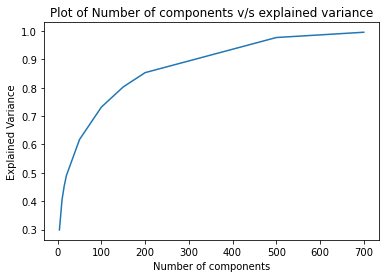

In [21]:
# Program to find the optimal number of components for Truncated SVD
n_comp = [4,10,15,20,50,100,150,200,500,700] # list containing different values of components
explained = [] # explained variance ratio for each component of Truncated SVD
for x in n_comp:
    svd = TruncatedSVD(n_components=x)
    svd.fit(lsa_words_text_embeddings)
    explained.append(svd.explained_variance_ratio_.sum())
    print("Number of components = %r and explained variance = %r"%(x,svd.explained_variance_ratio_.sum()))
plt.plot(n_comp, explained)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()

#### Name of embedding df: 
bert_words_text_embeddings <br>
lsa_words_text_embeddings <br><br>
bert_text_embeddings <br> 
lsa_text_embeddings <br> <br>
bert_words_embeddings <br> 
lsa_words_embeddings

In [88]:
X_train, X_test, y_train, y_test = reduce_dim_svd(bert_text_embeddings.values, k=50, split=True, sparse=True)

In [37]:
print(X_train.shape)
print(y_train.shape)

check_data_balance(y_train)

(764, 50)
(764,)


,count,prop
0,170,22.251309
1,163,21.335079
3,161,21.073298
2,136,17.801047
4,134,17.539267


In [38]:
ridge_model = Ridge(alpha=.1).fit(X_train, y_train)
y_pred = ridge_model.predict(X_test)

In [39]:
print("R2 score data:  ", ridge_model.score(X_test, y_test)) 
corr, _ = spearmanr(y_pred, y_test)
print('Spearmans correlation: ', corr)

print("MAE: ", mean_absolute_error(y_pred, y_test))
print("\nMSE: ", mean_squared_error(y_pred, y_test))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R2 score data:   0.27766824783363153
Spearmans correlation:  0.4889725728163372
MAE:  0.9926878136810615

MSE:  1.4502867662393528
RMSE: 1.204278525192305


#### With cross validation

In [89]:
cv = KFold(n_splits=10, shuffle=True)
ridge_model_CV = RidgeCV(alphas=[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0], cv=cv).fit(X_train, y_train)
y_predCV = ridge_model_CV.predict(X_test)

print('Alpha: ', ridge_model_CV.alpha_)
print("R2 score data:  ", ridge_model_CV.score(X_test, y_test)) 
corr, _ = spearmanr(y_predCV, y_test)
print('Spearmans correlation: ', corr)
print("MAE: ", mean_absolute_error(y_predCV, y_test))

Alpha:  1.0
R2 score data:   0.4320198703329332
Spearmans correlation:  0.6673245190119302
MAE:  0.8381469595702662


# Results table Ridge Regression w/ dependent variable PHQ classes 

|           | Embedding     | Dim reduction |  Alpha  |  Spearmans  |   R2  |  MAE  |
| :-------- | :------------:|:-------------:|: ------:|:-----------:|:-----:|:-----:|
| **Words + Text** | LSA           | PCA    |  1.0    | 0.568       | 0.297 | 0.979 |
| **Words + Text** | LSA           | UMAP   |  .01    | 0.638       | 0.398 | 0.888 |
| **Words + Text** | LSA           | SVD    |  1.0    | 0.478       | 0.266 | 1.00 |
| **Words + Text** | BERT          | PCA    |  1.0    | 0.719       | 0.528 | 0.764 |
| **Words + Text** | BERT          | UMAP   |  .005   | 0.548       | 0.259 | 0.957 |
| **Words + Text** | BERT          | SVD    |    1.0  | 0.717       | 0.522 | 0.763 |
| | | | | |
| | | | | |
| **Words**        | LSA           | PCA    |   1.0 | 0.470 | 0.151 | 1.040 |
| **Words**        | LSA           | UMAP   |  .5   | 0.683 | 0.492 | 0.813 |
| **Words**        | LSA           | SVD    |   1.0 | 0.528 | 0.309 | 0.945 |
| **Words**        | BERT          | PCA    |  1.0  | 0.574 | 0.322 | 0.956 |
| **Words**        | BERT          | UMAP   |  .001 | 0.643 | 0.447 | 0.847 |
| **Words**        | BERT          | SVD    |  1.0  | 0.678 | 0.480 | 0.787 |
| | | | | |
| | | | | |
|**Text**          | LSA           | PCA     |  1.0 | 0.396 | 0.089 | .099 |
|**Text**          | LSA           | UMAP    |  .01 | 0.312 | -0.122| 1.214|
|**Text**          | LSA           | SVD     |  1.0 | 0.366 | 0.135 | 1.12 |
|**Text**          | BERT          | PCA     |  1.0 | 0.691 | 0.436 | 0.868|
|**Text**          | BERT          | UMAP    |  .01 | 0.562 | 0.290 | 0.936|
|**Text**          | BERT          | SVD     |  1.0 | 0.667 | 0.432 | 0.838|

## Analysis using Multilayer Perceptron Neural Network for multi-class classification

In [ ]:
model = Sequential()
model.add(Dense(50, input_shape=(X_train.shape[1],), activation='relu')) #60,25, 10
model.add(Dropout(0.5))
model.add(Dense(25, activation='relu')) 
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
model.summary()

In [469]:
history = model.fit(X_train, y_train, batch_size=30, epochs=150, verbose=0, validation_data=(X_test, y_test))

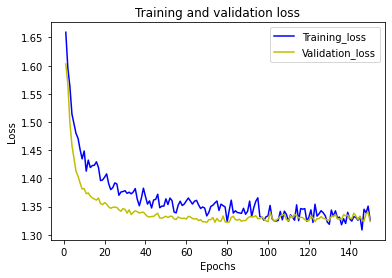

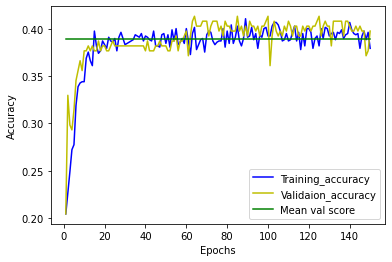

In [470]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, 151)
plt.plot(epochs, loss, 'b', label='Training_loss')
plt.plot(epochs, val_loss, 'y', label='Validation_loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
plt.plot(epochs, acc, 'b', label='Training_accuracy')
plt.plot(epochs, val_acc, 'y', label='Validaion_accuracy')
plt.plot(epochs, [statistics.mean(val_acc)]*len(epochs), 'g', label='Mean val score')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [471]:
y_pred_check = np.argmax(model.predict(X_test),axis=1)
sc, _ = spearmanr(y_pred_check, y_test)

print('Embedding with words_bert')
print('Spearmans correlation: ', sc)
print(classification_report(y_test, y_pred_check))

Embedding with words_bert
Spearmans correlation:  0.6424072470124967
              precision    recall  f1-score   support

           0       0.70      0.76      0.73        42
           1       0.30      0.20      0.24        41
           2       0.00      0.00      0.00        34
           3       0.31      0.90      0.46        40
           4       0.00      0.00      0.00        34

    accuracy                           0.40       191
   macro avg       0.26      0.37      0.28       191
weighted avg       0.28      0.40      0.31       191



In [72]:
from keybert import KeyBERT
kw_model = KeyBERT('distilbert-base-nli-mean-tokens')

In [74]:
tst = responses['Deptext'][2]
print(tst)
kw_model.extract_keywords(tst)

I have been depressed because I am worried about losing my job and doubtful whether I will find another one at my age.  This leads me to depression about the state of the country at the moment and the coronavirus pandemic and the incoming fiasco about Brexit.


[('depressed', 0.4539),
 ('pandemic', 0.383),
 ('depression', 0.3367),
 ('brexit', 0.262),
 ('worried', 0.2289)]

# Baseline

In [90]:
from sklearn.dummy import DummyClassifier, DummyRegressor

In [88]:
#Stratified generates random predictions by respecting the training set class distribution.
dummy_model = DummyClassifier(strategy='stratified', random_state=0)

X_dummy = lsa_words_text_embeddings.values

X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy = split_train_test(X_dummy, responses['PHQ_class'])

dummy_model.fit(X_train_dummy, y_train_dummy)
y_pred_dummy = dummy_model.predict(X_test_dummy) 


sc_dummy, _ = spearmanr(y_pred_dummy, y_test_dummy)

print('Dummy predictions:')
print('Spearmans correlation: ', sc_dummy)
print(classification_report(y_test_dummy, y_pred_dummy))

Dummy predictions:
Spearmans correlation:  0.10269890116528162
              precision    recall  f1-score   support

           0       0.29      0.31      0.30        42
           1       0.28      0.27      0.27        41
           2       0.19      0.12      0.15        34
           3       0.27      0.28      0.27        40
           4       0.16      0.21      0.18        34

    accuracy                           0.24       191
   macro avg       0.24      0.24      0.23       191
weighted avg       0.24      0.24      0.24       191



In [97]:
dummy_regr = DummyRegressor(strategy="mean")

X_dummy = bert_words_text_embeddings.values
X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy = split_train_test(X_dummy, responses['PHQ_class'])

dummy_regr.fit(X_train_dummy, y_train_dummy)
y_pred_dummy = dummy_regr.predict(X_test_dummy) 

print(y_pred_dummy)

sc_dummy, _ = spearmanr(y_pred_dummy, y_test_dummy)

print('Spearmans correlation: ', sc_dummy)
print("R2 score data:  ", dummy_regr.score(X_test_dummy, y_test_dummy)) 
print("MAE: ", mean_absolute_error(y_pred_dummy, y_test_dummy))

[1.90314136 1.90314136 1.90314136 1.90314136 1.90314136 1.90314136
 1.90314136 1.90314136 1.90314136 1.90314136 1.90314136 1.90314136
 1.90314136 1.90314136 1.90314136 1.90314136 1.90314136 1.90314136
 1.90314136 1.90314136 1.90314136 1.90314136 1.90314136 1.90314136
 1.90314136 1.90314136 1.90314136 1.90314136 1.90314136 1.90314136
 1.90314136 1.90314136 1.90314136 1.90314136 1.90314136 1.90314136
 1.90314136 1.90314136 1.90314136 1.90314136 1.90314136 1.90314136
 1.90314136 1.90314136 1.90314136 1.90314136 1.90314136 1.90314136
 1.90314136 1.90314136 1.90314136 1.90314136 1.90314136 1.90314136
 1.90314136 1.90314136 1.90314136 1.90314136 1.90314136 1.90314136
 1.90314136 1.90314136 1.90314136 1.90314136 1.90314136 1.90314136
 1.90314136 1.90314136 1.90314136 1.90314136 1.90314136 1.90314136
 1.90314136 1.90314136 1.90314136 1.90314136 1.90314136 1.90314136
 1.90314136 1.90314136 1.90314136 1.90314136 1.90314136 1.90314136
 1.90314136 1.90314136 1.90314136 1.90314136 1.90314136 1.9031

## Logistic regression to predict diagnosis 

In [ ]:
#Creates a dataframe with the columns containing responses for depression questions and then applies aggregation and concatination

def get_responses_data():
    
    #Get relative directory to find path
    path = os.path.join(os.getcwd(), 'data', 'response_format_cleaned_ds1.csv')
    responses = pd.read_csv(path, sep=';', header=0)
    responses.drop(responses.columns[[0]], axis=1, inplace=True)
    
    #Drop rows with NA values 
    responses = responses[~responses.dep_all_phraces.str.contains("NA NA NA NA NA")]
    responses = responses[~responses.dep_all_words.str.contains("NA NA NA NA NA")]
    responses = responses.reset_index(drop=True)
    responses.dropna(subset=['Deptext'], inplace=True)
    return responses


def get_x_lsa_dep():
    responses=get_responses_data()
    dep_columns = ['Deptext', 'dep_all_phraces', 'dep_all_words', 'dep_all_selected1']
    df_dep_responses = responses[dep_columns]
    df_dep_aggregated = df_dep_responses.apply(aggregate_cell, axis=1)
    x_dep_lsa=pd.DataFrame(list(df_dep_aggregated.apply(concat_vectors, axis=1)))
    return x_dep_lsa





In [16]:
#Storing the binary variable, whether someone is diagnosed with dep or not

def get_binary_y(responses):
    dep_diag = responses[['minidep_diagnose']]
    
    #Checking for NaN values
    dep_diag.isnull().values.any() #false

    #Create y - variables
    y_dep_diag = dep_diag.values
    return y_dep_diag



In [19]:
responses=get_responses_data()

#Depression data
X_dep_lsa=get_x_lsa_dep()
y_dep = get_binary_y(responses)


print("Respondents with depression diagnose: {} out of {}".format(int(y_dep.sum()), len(y_dep))) #unbalanced

Respondents with depression diagnose: 320 out of 952


#### Import packages

In [26]:
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score
from sklearn.metrics import f1_score, confusion_matrix, matthews_corrcoef, classification_report, accuracy_score, balanced_accuracy_score
from sklearn import metrics
from sklearn.pipeline import Pipeline, make_pipeline
import matplotlib.pyplot as plt
from numpy import mean
from sklearn.decomposition import PCA


#### Evaluation metrics

In [22]:
def get_eval(y_test,y_pred):
    acc=metrics.accuracy_score(y_test, y_pred )
    mcc=metrics.matthews_corrcoef(y_test, y_pred)
    bal_acc=balanced_accuracy_score(y_test, y_pred)
    cm=pd.crosstab(y_test, y_pred, margins=True, rownames=['Actual'], colnames=['Predicted'])
    cr = classification_report(y_test,y_pred)
    return acc, mcc, bal_acc, cm, cr

#### Baseline predictions

In [23]:
from sklearn.dummy import DummyClassifier

In [24]:
#Stratified generates random predictions by respecting the training set class distribution.
dummy_model= DummyClassifier(strategy='stratified', random_state=0)

X_train_dep, X_test_dep, y_train_dep, y_test_dep= split_train_test(X_dep_lsa, y_dep)

dummy_model.fit(X_train_dep, y_train_dep)
y_pred_dep=dummy_model.predict(X_test_dep) 
acc_dep, mcc_dep, bal_acc_dep, cm_dep, cr_dep= get_eval(y_test_dep, y_pred_dep)
print(cr_dep)

              precision    recall  f1-score   support

           0       0.68      0.69      0.69       127
           1       0.37      0.36      0.37        64

    accuracy                           0.58       191
   macro avg       0.53      0.53      0.53       191
weighted avg       0.58      0.58      0.58       191



#### Dimensionality reduction - PCA

In [27]:
#Analysing number of components to use for PCA
def get_scores(model, X, y):
    score = np.mean(cross_val_score(model, X, y, n_jobs=-1, scoring='f1')) 
    return score

def get_nbr_components_pca(X, y, start=1, stop=300):
    pca_scores=[]
    models = dict()
    start, stop=start, stop
    X_train, X_test, y_train, y_test= split_train_test(X, y)
    for i in range(start,stop): 
        model=make_pipeline(PCA(n_components=i), LogisticRegression())
        score = get_scores(model, X_train, y_train)
        pca_scores.append(score)
    n_components_pca=np.argmax(pca_scores)+1+start
    return pca_scores, n_components_pca

def plot_nbr_components_pca(pca_scores, start, stop):
    if len(pca_scores)>0:
        n=np.arange(start, stop, step=1, dtype=int)
        plt.figure()
        plt.plot(n, pca_scores)
        plt.xlabel("Number of components")
        plt.ylabel("PCA score")
        plt.show()


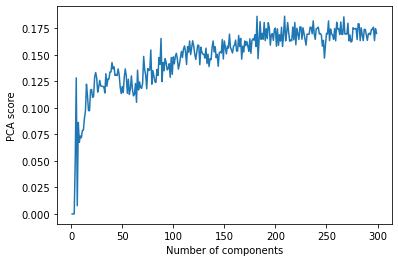

Nbr of components to use for PCA dimension reduction on dep. dataset:  210


In [28]:
#Testing for number of components to use for PCA dimension reduction on dep. dataset
#takes a long time running 
start, stop=1,300
pca_scores_dep, nbr_components_dep= get_nbr_components_pca(X_dep_lsa, y_dep, start, stop)
plot_nbr_components_pca(pca_scores_dep, start, stop)
print("Nbr of components to use for PCA dimension reduction on dep. dataset: ", nbr_components_dep)
#with f1-scoring: [96, 198, 266]

In [33]:
#Analysing number of components to use for PCA using GridSearchCV

pipe = Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()), ('model', LogisticRegression())])

#values of the parameters to test on the pipeline
param_grid = {
    'pca__n_components': np.arange(start=1, stop=300, step=1, dtype=int), #[3,4,5,16, 96, 199, 198, 266, 300],
    'model__C': [0.0001, 0.001,0.01, 0.1, 1, 10,100, 1000] 
}

grid_searcher = GridSearchCV(pipe, param_grid, n_jobs=-1, scoring='f1') 
X_train, X_test, y_train, y_test = split_train_test(X_dep_lsa, y_dep)
grid_searcher.fit(X_train, y_train)

In [ ]:
#identifies the best estimator from the combination of parameter values
estimator = grid_searcher.best_estimator_
y_pred = estimator.predict(X_test)
print(estimator)

#evaluate result
acc, mcc, bal_acc, cm, cr= get_eval(y_test, y_pred)
print(cr)

### Evaluation on logistic regression model

In [36]:
X_train, X_test, y_train, y_test= split_train_test(X_dep_lsa, y_dep)

model = make_pipeline(StandardScaler(), PCA(n_components=300), umap.UMAP(n_neighbors=5,n_components=150, min_dist=0.3),LogisticRegression(C=10)) 
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc, mcc, bal_acc, cm, cr= get_eval(y_test,y_pred)
print(cr)



/Users/alexandraantgren/opt/anaconda3/envs/ml2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       0.79      0.79      0.79       127
           1       0.58      0.58      0.58        64

    accuracy                           0.72       191
   macro avg       0.68      0.68      0.68       191
weighted avg       0.72      0.72      0.72       191

